Примітка:

В якості цільової змінної для моделі був вибраний стовпець "target_full_ltv_day30".

Окремо було розглянуто ансамбль моделей які прогнозують три складові змінні "target_full_ltv_day30". Аналіз результатів тренування ансамблю моделей показав гірші результати. Тому остаточний алгоритм прогнозує стовпець "target_full_ltv_day30".

In [19]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import lightgbm as lgb
import ast
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn import feature_selection
import optuna

import shap
shap.initjs()
import fasttreeshap
SEED = 47


pd.set_option('display.max_columns', None)
pd.options.display.float_format ='{:,.3f}'.format
pd.options.mode.chained_assignment = None
pd.options.mode.chained_assignment = None

На основі EDA було вирішено брати нелінійну модель. За основу взяли градієнтний бустинг LightGBM. 

# PREPROC

З EDA відомо, що потрібно замінити NaN, а також проіндексувати категоріальні змінні.

In [14]:
df = pd.read_csv('TEST TASK (dataset).csv')
df['country_code'] = df['country_code'].apply(lambda x: int(x.split('_')[1]))
df['media_source'] = df['media_source'].apply(lambda x: int(x.split('_')[1]))
df['platform'] = np.where(df['platform'] == 'android', 1, 0)
df = df.dropna()
df

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,chapters_opened_day3,chapters_opened_day7,chapters_closed_day0,chapters_closed_day1,chapters_closed_day3,chapters_closed_day7,diamonds_received_day0,diamonds_received_day1,diamonds_received_day3,diamonds_received_day7,diamonds_spent_day0,diamonds_spent_day1,diamonds_spent_day3,diamonds_spent_day7,tickets_spent_day0,tickets_spent_day1,tickets_spent_day3,tickets_spent_day7,retained_day1,retained_day3,retained_day7,chapters_finished_session1,chapters_finished_session3,chapters_finished_session9,chapters_opened_session1,chapters_opened_session3,chapters_opened_session9,chapters_closed_session1,chapters_closed_session3,chapters_closed_session9,diamonds_spent_session1,diamonds_spent_session3,diamonds_spent_session9,tickets_spent_session1,tickets_spent_session3,tickets_spent_session9,app_sub_ltv_day0,app_sub_ltv_day1,app_sub_ltv_day3,app_iap_ltv_day0,app_iap_ltv_day1,app_iap_ltv_day3,media_source,install_date,country_code,ad_ltv_day0,ad_ltv_day1,ad_ltv_day3,platform,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30
0,1.000,1.000,1.000,1.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,23,2021-12-03,135,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000
1,1.000,1.000,1.000,1.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,2,2021-12-03,141,0.000,0.000,0.000,1,0.000,0.000,0.000,0.000
2,1.000,2.000,2.000,2.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,17,2021-12-03,141,0.000,0.000,0.000,1,0.000,0.000,0.000,0.000
3,1.000,1.000,1.000,1.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,23,2021-12-03,141,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000
4,1.000,1.000,1.000,1.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,1,2021-12-03,203,0.000,0.000,0.000,1,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467827,11.000,11.000,11.000,11.000,9,9,9,9,10,10,10,10,3,3,3,3,282,282,282,282,254,254,254,254,7,7,7,7,0,0,0,1,1,8,2,2,9,0,0,3,29,29,237,1,1,6,0.000,0.000,0.000,4.174,4.174,4.174,17,2021-12-30,141,0.037,0.037,0.037,0,0.000,4.174,0.037,4.211
1467828,2.000,3.000,6.000,7.000,5,9,11,13,6,10,12,13,0,0,0,0,346,554,658,732,254,542,658,721,5,9,11,12,1,1,0,3,9,13,4,10,13,0,0,0,174,542,721,3,9,12,0.000,0.000,1.176,4.900,7.841,9.404,23,2021-12-30,141,0.039,0.039,0.091,0,4.705,10.968,0.091,15.764
1467829,3.000,5.000,11.000,13.000,5,9,15,18,5,10,16,19,0,0,0,0,265,497,857,913,254,496,809,901,4,8,13,16,1,1,0,0,5,13,1,5,14,0,0,0,0,254,685,0,4,12,0.000,0.000,0.000,4.036,8.876,13.928,23,2021-12-30,141,0.000,0.000,0.000,0,0.000,14.938,0.000,14.938
1467830,5.000,5.000,5.000,5.000,24,24,24,24,24,24,24,24,7,7,7,7,1308,1308,1308,1308,1278,1278,1278,1278,12,12,12,12,0,0,0,9,23,25,10,23,25,4,7,7,524,1249,1295,6,12,12,0.000,0.000,0.000,7.402,7.402,7.402,4,2021-12-30,141,0.178,0.178,0.178,0,0.000,7.402,0.178,7.580


# COLS

Було проведено декілька експериментів з різними фічами (з різною кількістю фічей). Наразі остаточна модель використовує всі фічі окрім install_date. Вона дала найкращий результат порівняно з варінтами, коли ми видаляли якусь кількість фічей з датасету (результат погіршувався надто помітно).

In [5]:
cols = ['total_sessions_day0',
 'total_sessions_day1',
 'total_sessions_day3',
 'total_sessions_day7',
 'chapters_finished_day0',
 'chapters_finished_day1',
 'chapters_finished_day3',
 'chapters_finished_day7',
 'chapters_opened_day0',
 'chapters_opened_day1',
 'chapters_opened_day3',
 'chapters_opened_day7',
 'chapters_closed_day0',
 'chapters_closed_day1',
 'chapters_closed_day3',
 'chapters_closed_day7',
 'diamonds_received_day0',
 'diamonds_received_day1',
 'diamonds_received_day3',
 'diamonds_received_day7',
 'diamonds_spent_day0',
 'diamonds_spent_day1',
 'diamonds_spent_day3',
 'diamonds_spent_day7',
 'tickets_spent_day0',
 'tickets_spent_day1',
 'tickets_spent_day3',
 'tickets_spent_day7',
 'retained_day1',
 'retained_day3',
 'retained_day7',
 'chapters_finished_session1',
 'chapters_finished_session3',
 'chapters_finished_session9',
 'chapters_opened_session1',
 'chapters_opened_session3',
 'chapters_opened_session9',
 'chapters_closed_session1',
 'chapters_closed_session3',
 'chapters_closed_session9',
 'diamonds_spent_session1',
 'diamonds_spent_session3',
 'diamonds_spent_session9',
 'tickets_spent_session1',
 'tickets_spent_session3',
 'tickets_spent_session9',
 'app_sub_ltv_day0',
 'app_sub_ltv_day1',
 'app_sub_ltv_day3',
 'app_iap_ltv_day0',
 'app_iap_ltv_day1',
 'app_iap_ltv_day3',
 'media_source',
 'country_code',
 'ad_ltv_day0',
 'ad_ltv_day1',
 'ad_ltv_day3',
 'platform',
]

Розбиваємо датасет на тренувальну, валідаційну та тестову вибірки. Робимо 60% трейн, 20% валідація та 20% тест. 

In [15]:
X = df.drop(columns=['target_full_ltv_day30'])
y = df['target_full_ltv_day30']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 
# 0.25 x 0.8 = 0.2

X_train = X_train[cols]
X_val = X_val[cols]
X_test = X_test[cols]

print(f'Shape of train: X - {X_train.shape}, y - {y_train.shape}')
print(f'Shape of val: X - {X_val.shape}, y - {y_val.shape}')
print(f'Shape of test: X - {X_test.shape}, y - {y_test.shape}')

Shape of train: X - (879874, 58), y - (879874,)
Shape of val: X - (293292, 58), y - (293292,)
Shape of test: X - (293292, 58), y - (293292,)


# OPTUNA

Тут ми використовуємо метод підбору гіперпараметрів. В оптуні використовуємо дві метрики: pearson та bias (формули написані нижче). Ці метрики дають найкращий результат. 

Ми обрали список найважливіших гіперпараметрів та задали для них діапазони значень властиві для них. Щодо цільової метрики (параметр "objective") ми вибрали MAE, тому що значення цільової змінної дуже близько до нуля і дуже часто приймає саме нульові значення. Метрику MAPE не можна використовувати просто навіть за визначенням. RMSE погано працює на малих значення цільової змінної. 

In [10]:
def pearson(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]


def bias(y_true, y_pred):
    return abs(np.sum(y_pred - y_true) / np.sum(y_true) * 100)


def mse_metric(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [11]:
from statistics import mean

def objective(trial, train_list, val_list, test_list, metrics_config):
    X_train, y_train = train_list
    X_val, y_val = val_list
    X_test, y_test = test_list
    
    dataset = lgb.Dataset(X_train, y_train)
    param = {"objective": trial.suggest_categorical("objective", ['mae']), # mape, rmse, mae
             "verbosity": trial.suggest_categorical("verbosity", [-1]),
             "n_jobs": trial.suggest_categorical("n_jobs", [4]),
             "boosting_type": trial.suggest_categorical("boosting_type", ['gbdt']),
             "n_estimators": trial.suggest_categorical("n_estimators", [300]),
             
             "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
             "max_depth": trial.suggest_int('max_depth', 5, 100, step=1),
             "num_leaves": trial.suggest_int('num_leaves', 5, 1005, step=10),
             "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
             "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
             "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 1, step=0.1),
             "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 1, step=0.1),
             "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 10010, step=20),
             "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
             "bagging_freq": trial.suggest_int('bagging_freq', 1, 6, step=1)}

    lgbm = lgb.train(params=param, train_set=dataset)
            
    metric_to_return = dict()
    for metric_name, config in metrics_config.items():
        metric_to_return[metric_name] = config['metric_function'](y_val, lgbm.predict(X_val))
        
    return tuple(metric_to_return.values())

In [12]:
multi_config = {'bias': {'metric_function': bias, 'direction': 'minimize'},
                'pearson': {'metric_function': pearson, 'direction': 'maximize'}}

train_list = [X_train, y_train]
val_list = [X_val, y_val]
test_list = [X_test, y_test]

study = optuna.create_study(directions=[i['direction'] for i in multi_config.values()])
study.optimize(lambda trial: objective(trial, train_list, val_list, test_list, multi_config), n_trials=100) 

[I 2022-09-09 21:18:22,275] A new study created in memory with name: no-name-666878f5-ec1c-4e2b-8905-2081bf23e8ec
Found `n_estimators` in params. Will use it instead of argument
[I 2022-09-09 21:18:42,105] Trial 0 finished with values: [22.67093587340866, 0.7843757800607405] and parameters: {'objective': 'mae', 'verbosity': -1, 'n_jobs': 4, 'boosting_type': 'gbdt', 'n_estimators': 300, 'learning_rate': 0.22411309615177175, 'max_depth': 93, 'num_leaves': 425, 'lambda_l1': 0.0029124027898701343, 'lambda_l2': 7.738441590863956e-06, 'feature_fraction': 0.4, 'bagging_fraction': 0.7, 'min_data_in_leaf': 2350, 'min_gain_to_split': 14.022373955159969, 'bagging_freq': 3}. 
[I 2022-09-09 21:19:03,117] Trial 1 finished with values: [32.362645132230455, 0.7053925353533016] and parameters: {'objective': 'mae', 'verbosity': -1, 'n_jobs': 4, 'boosting_type': 'gbdt', 'n_estimators': 300, 'learning_rate': 0.076933614862478, 'max_depth': 70, 'num_leaves': 405, 'lambda_l1': 0.22200375626283972, 'lambda_l

[I 2022-09-09 21:23:44,490] Trial 16 finished with values: [40.41901487551646, 0.6312469497530578] and parameters: {'objective': 'mae', 'verbosity': -1, 'n_jobs': 4, 'boosting_type': 'gbdt', 'n_estimators': 300, 'learning_rate': 0.041354604399219674, 'max_depth': 17, 'num_leaves': 575, 'lambda_l1': 0.0014341680722940375, 'lambda_l2': 4.179279959007633e-06, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'min_data_in_leaf': 9770, 'min_gain_to_split': 11.638696064757747, 'bagging_freq': 1}. 
[I 2022-09-09 21:23:57,738] Trial 17 finished with values: [19.66226807809268, 0.800779653161436] and parameters: {'objective': 'mae', 'verbosity': -1, 'n_jobs': 4, 'boosting_type': 'gbdt', 'n_estimators': 300, 'learning_rate': 0.2887277102296643, 'max_depth': 15, 'num_leaves': 635, 'lambda_l1': 0.00015766841358683201, 'lambda_l2': 0.012893819353581014, 'feature_fraction': 0.30000000000000004, 'bagging_fraction': 0.5, 'min_data_in_leaf': 1110, 'min_gain_to_split': 11.58440985977793, 'bagging_freq':

[I 2022-09-09 21:28:52,519] Trial 32 finished with values: [23.307863739975105, 0.7726296358407015] and parameters: {'objective': 'mae', 'verbosity': -1, 'n_jobs': 4, 'boosting_type': 'gbdt', 'n_estimators': 300, 'learning_rate': 0.2943778203679713, 'max_depth': 99, 'num_leaves': 385, 'lambda_l1': 1.910321479659078, 'lambda_l2': 0.00013145740863590116, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0, 'min_data_in_leaf': 4470, 'min_gain_to_split': 6.248854899217269, 'bagging_freq': 2}. 
[I 2022-09-09 21:29:09,114] Trial 33 finished with values: [21.95371888017865, 0.7926756918312179] and parameters: {'objective': 'mae', 'verbosity': -1, 'n_jobs': 4, 'boosting_type': 'gbdt', 'n_estimators': 300, 'learning_rate': 0.09783580697702648, 'max_depth': 8, 'num_leaves': 325, 'lambda_l1': 4.3424719321515735, 'lambda_l2': 1.3029219643646138e-08, 'feature_fraction': 0.30000000000000004, 'bagging_fraction': 0.4, 'min_data_in_leaf': 1070, 'min_gain_to_split': 7.940030518305196, 'baggi

[I 2022-09-09 21:34:02,836] Trial 48 finished with values: [30.41267630847499, 0.7056728762050409] and parameters: {'objective': 'mae', 'verbosity': -1, 'n_jobs': 4, 'boosting_type': 'gbdt', 'n_estimators': 300, 'learning_rate': 0.27874773028127264, 'max_depth': 41, 'num_leaves': 865, 'lambda_l1': 0.00041832244672285196, 'lambda_l2': 0.02609377371506901, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'min_data_in_leaf': 6910, 'min_gain_to_split': 1.1469705926438585, 'bagging_freq': 2}. 
[I 2022-09-09 21:34:32,645] Trial 49 finished with values: [23.266831265734226, 0.7773620815324662] and parameters: {'objective': 'mae', 'verbosity': -1, 'n_jobs': 4, 'boosting_type': 'gbdt', 'n_estimators': 300, 'learning_rate': 0.2323614606961325, 'max_depth': 48, 'num_leaves': 175, 'lambda_l1': 0.09457354525666249, 'lambda_l2': 0.004597054045675403, 'feature_fraction': 0.7, 'bagging_fraction': 0.9000000000000001, 'min_data_in_leaf': 3810, 'min_gain_to_split': 6.986474833454574, 'bagging_freq': 2}.

[I 2022-09-09 21:39:35,538] Trial 64 finished with values: [30.282426385725188, 0.7101374984857088] and parameters: {'objective': 'mae', 'verbosity': -1, 'n_jobs': 4, 'boosting_type': 'gbdt', 'n_estimators': 300, 'learning_rate': 0.18905919125818302, 'max_depth': 64, 'num_leaves': 15, 'lambda_l1': 3.4985148291721316e-08, 'lambda_l2': 3.6906559847050407e-07, 'feature_fraction': 0.4, 'bagging_fraction': 0.8, 'min_data_in_leaf': 7350, 'min_gain_to_split': 7.491034041998688, 'bagging_freq': 2}. 
[I 2022-09-09 21:39:55,909] Trial 65 finished with values: [29.450473215351124, 0.7112548541289783] and parameters: {'objective': 'mae', 'verbosity': -1, 'n_jobs': 4, 'boosting_type': 'gbdt', 'n_estimators': 300, 'learning_rate': 0.27883774499226094, 'max_depth': 70, 'num_leaves': 85, 'lambda_l1': 2.4087785215056063e-06, 'lambda_l2': 0.3328453587810998, 'feature_fraction': 0.2, 'bagging_fraction': 0.9000000000000001, 'min_data_in_leaf': 8650, 'min_gain_to_split': 2.2312456697993093, 'bagging_freq':

[I 2022-09-09 21:44:42,523] Trial 80 finished with values: [27.80953745896342, 0.7357217364740742] and parameters: {'objective': 'mae', 'verbosity': -1, 'n_jobs': 4, 'boosting_type': 'gbdt', 'n_estimators': 300, 'learning_rate': 0.16964436988536716, 'max_depth': 84, 'num_leaves': 145, 'lambda_l1': 0.0077389278933647, 'lambda_l2': 7.028081881906672, 'feature_fraction': 0.30000000000000004, 'bagging_fraction': 0.5, 'min_data_in_leaf': 3550, 'min_gain_to_split': 2.777607621377307, 'bagging_freq': 3}. 
[I 2022-09-09 21:44:59,595] Trial 81 finished with values: [32.17709061542433, 0.6983864856449606] and parameters: {'objective': 'mae', 'verbosity': -1, 'n_jobs': 4, 'boosting_type': 'gbdt', 'n_estimators': 300, 'learning_rate': 0.12793582088070657, 'max_depth': 67, 'num_leaves': 225, 'lambda_l1': 1.143644216693787, 'lambda_l2': 0.00032574609121231447, 'feature_fraction': 0.7, 'bagging_fraction': 0.6000000000000001, 'min_data_in_leaf': 6290, 'min_gain_to_split': 8.697530130030483, 'bagging_f

[I 2022-09-09 21:49:33,493] Trial 96 finished with values: [18.230107876018426, 0.822416492468393] and parameters: {'objective': 'mae', 'verbosity': -1, 'n_jobs': 4, 'boosting_type': 'gbdt', 'n_estimators': 300, 'learning_rate': 0.2817980811654228, 'max_depth': 50, 'num_leaves': 895, 'lambda_l1': 0.019686594860219522, 'lambda_l2': 1.9018065667095951e-06, 'feature_fraction': 0.7, 'bagging_fraction': 0.8, 'min_data_in_leaf': 1250, 'min_gain_to_split': 9.66207676900587, 'bagging_freq': 3}. 
[I 2022-09-09 21:49:52,245] Trial 97 finished with values: [30.27906605249358, 0.7112034783009757] and parameters: {'objective': 'mae', 'verbosity': -1, 'n_jobs': 4, 'boosting_type': 'gbdt', 'n_estimators': 300, 'learning_rate': 0.1540013250879292, 'max_depth': 82, 'num_leaves': 395, 'lambda_l1': 7.4371270659828874e-06, 'lambda_l2': 3.651961133886657e-08, 'feature_fraction': 0.5, 'bagging_fraction': 0.6000000000000001, 'min_data_in_leaf': 5850, 'min_gain_to_split': 13.491896462186205, 'bagging_freq': 5

Виводимо найкращі за версією оптуни гіперпараметри та метрики які ми отримали.

In [13]:
print(len(study.best_trials))
par = []
par_metr = []
for i in study.best_trials:
    print(i.params)
    print()
    par.append(i.params)


for i in study.best_trials:
    print(i.values)
    print()
    par_metr.append(i.values)

1
{'objective': 'mae', 'verbosity': -1, 'n_jobs': 4, 'boosting_type': 'gbdt', 'n_estimators': 300, 'learning_rate': 0.2705758020792662, 'max_depth': 96, 'num_leaves': 675, 'lambda_l1': 4.920521482671028, 'lambda_l2': 0.11026052778101658, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'min_data_in_leaf': 110, 'min_gain_to_split': 2.352800364785508, 'bagging_freq': 3}

[13.363318321295791, 0.8872937737674861]



# MODEL

Остаточне тренування моделі та отримання фінальних метрик і результатів. Цільова метрика MAE але ми виводимо декілька метрик аби краще оцінити результати.

In [14]:
def our_metricks(preds, train_data):
    labels = train_data.get_label()
    bais = ('bais', abs(np.mean(((sum(labels) - sum(preds)) / sum(labels)))) * 100, False)
    pearson_ = ('pearson', pearsonr(labels, preds)[0], True)
    r2 = ('r2_score', r2_score(labels, preds), True)
    return [bais, pearson_, r2]


def print_metr(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    bais = np.mean(((sum(y_true) - sum(y_pred)) / sum(y_true))) * 100
    
    print(f'RMSE of prediction is: {rmse}')
    print(f'MSE of prediction is: {mse}')
    print(f'MAE of prediction is: {mae}')
    print(f'r2 of prediction is: {r2}')
    print(f'Bais of prediction is: {bais}%')

    
def only_train_model(list_x, list_y, params, save_model=False):
    X_train, X_val, X_test = list_x
    y_train, y_val, y_test = list_y

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
        
    d = {}
    gbm = lgb.train(params,
                lgb_train,
                evals_result=d,
                feval=our_metricks, 
                valid_sets=lgb_val)
    

    if save_model:
        pickle.dump(gbm, open(f'model_new.pkl', 'wb'))
    
    
    y_pred_train = gbm.predict(X_train)
    y_pred_val = gbm.predict(X_val)
    y_pred_test = gbm.predict(X_test)

    print(f'Metrics for train: ')
    print_metr(y_train, y_pred_train)
    
    print(f'Metrics for val: ')
    print_metr(y_val, y_pred_val)
    
    print(f'Metrics for test: ')
    print_metr(y_test, y_pred_test)
    
    X_train['target_full_ltv_day30'] = y_train
    X_val['target_full_ltv_day30'] = y_val
    X_test['target_full_ltv_day30'] = y_test
    
    X_train['label'] = "train"  
    X_val['label'] = "val"  
    X_test['label'] = "test"
    
    X_train['y_pred'] = y_pred_train 
    X_val['y_pred'] = y_pred_val
    X_test['y_pred'] = y_pred_test
    
    total_set = pd.concat([X_train, X_val, X_test])
    total_set.reset_index(inplace=True, drop=True)
    
    
    return total_set, d

In [16]:
params = par[0]

params['metric'] = {'mean_squared_error', 'mean_absolute_error', 'root_mean_squared_error', 'mape'}

list_x = [X_train, X_val, X_test]
list_y = [y_train, y_val, y_test]

start_time_train = time.time()
total_set_all, d = only_train_model(list_x, list_y, params, True)
finish_time_train = time.time()

'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.


[1]	valid_0's mape: 0.0544898	valid_0's rmse: 2.13487	valid_0's l1: 0.248454	valid_0's l2: 4.55768	valid_0's bais: 97.5713	valid_0's pearson: 0.14885	valid_0's r2_score: -0.00838851
[2]	valid_0's mape: 0.0517667	valid_0's rmse: 2.12832	valid_0's l1: 0.243925	valid_0's l2: 4.52974	valid_0's bais: 95.0681	valid_0's pearson: 0.169065	valid_0's r2_score: -0.00220793
[3]	valid_0's mape: 0.0471354	valid_0's rmse: 2.11553	valid_0's l1: 0.235879	valid_0's l2: 4.47549	valid_0's bais: 91.2641	valid_0's pearson: 0.230582	valid_0's r2_score: 0.00979597
[4]	valid_0's mape: 0.0417459	valid_0's rmse: 2.09482	valid_0's l1: 0.225049	valid_0's l2: 4.38827	valid_0's bais: 86.1994	valid_0's pearson: 0.301787	valid_0's r2_score: 0.0290927
[5]	valid_0's mape: 0.0336944	valid_0's rmse: 2.00979	valid_0's l1: 0.19785	valid_0's l2: 4.03925	valid_0's bais: 74.3565	valid_0's pearson: 0.490404	valid_0's r2_score: 0.106314
[6]	valid_0's mape: 0.0270732	valid_0's rmse: 1.90488	valid_0's l1: 0.170044	valid_0's l2: 3.

[47]	valid_0's mape: 0.0141089	valid_0's rmse: 1.00828	valid_0's l1: 0.0663984	valid_0's l2: 1.01664	valid_0's bais: 13.5748	valid_0's pearson: 0.886775	valid_0's r2_score: 0.775068
[48]	valid_0's mape: 0.0141011	valid_0's rmse: 1.00793	valid_0's l1: 0.0663836	valid_0's l2: 1.01592	valid_0's bais: 13.551	valid_0's pearson: 0.886778	valid_0's r2_score: 0.775227
[49]	valid_0's mape: 0.0140982	valid_0's rmse: 1.00679	valid_0's l1: 0.0662513	valid_0's l2: 1.01362	valid_0's bais: 13.4689	valid_0's pearson: 0.887061	valid_0's r2_score: 0.775736
[50]	valid_0's mape: 0.0140954	valid_0's rmse: 1.00686	valid_0's l1: 0.0662464	valid_0's l2: 1.01376	valid_0's bais: 13.4826	valid_0's pearson: 0.887066	valid_0's r2_score: 0.775704
[51]	valid_0's mape: 0.0140891	valid_0's rmse: 1.00682	valid_0's l1: 0.0662394	valid_0's l2: 1.01369	valid_0's bais: 13.4922	valid_0's pearson: 0.887076	valid_0's r2_score: 0.77572
[52]	valid_0's mape: 0.0140838	valid_0's rmse: 1.00651	valid_0's l1: 0.0661943	valid_0's l2:

[93]	valid_0's mape: 0.014069	valid_0's rmse: 1.00425	valid_0's l1: 0.0660596	valid_0's l2: 1.00853	valid_0's bais: 13.3685	valid_0's pearson: 0.88726	valid_0's r2_score: 0.776863
[94]	valid_0's mape: 0.0140658	valid_0's rmse: 1.00428	valid_0's l1: 0.0660587	valid_0's l2: 1.00857	valid_0's bais: 13.3738	valid_0's pearson: 0.887258	valid_0's r2_score: 0.776853
[95]	valid_0's mape: 0.0140655	valid_0's rmse: 1.00433	valid_0's l1: 0.0660602	valid_0's l2: 1.00867	valid_0's bais: 13.3874	valid_0's pearson: 0.88728	valid_0's r2_score: 0.776831
[96]	valid_0's mape: 0.0140636	valid_0's rmse: 1.00411	valid_0's l1: 0.0660541	valid_0's l2: 1.00824	valid_0's bais: 13.3627	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776926
[97]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3634	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[98]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 

[138]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[139]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[140]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[141]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[142]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[143]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid

[183]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[184]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[185]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[186]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[187]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[188]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid

[228]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[229]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[230]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[231]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[232]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[233]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid

[273]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[274]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[275]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[276]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[277]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid_0's l2: 1.00825	valid_0's bais: 13.3633	valid_0's pearson: 0.887294	valid_0's r2_score: 0.776924
[278]	valid_0's mape: 0.0140632	valid_0's rmse: 1.00412	valid_0's l1: 0.0660538	valid

In [17]:
print("--- %s seconds ---" % (finish_time_train - start_time_train))
print("--- %s mins ---" % ((finish_time_train - start_time_train) / 60))
print("--- %s hours ---" % ((finish_time_train - start_time_train) / 3600))

--- 84.57072734832764 seconds ---
--- 1.4095121224721272 mins ---
--- 0.023491868707868787 hours ---


# SHAP

Далі ми аналізуємо вплив фічей на результат моделі за допомогою бібліотеки SHAP.

In [18]:
total_set_all_ = total_set_all[total_set_all['label'] == 'test'].copy()
total_set_all_ = total_set_all_[cols]
nam = 'preds.csv'
total_set_all_.to_csv(nam, index=False)

In [19]:
class ShapTreeExplainer():
    def __init__(self,
                 path_to_model=None,
                 path_to_data=None):

        self._data = pd.DataFrame([])
        
        if path_to_model:
            self.load_model(path_to_model)
        if path_to_data:
            self.load_data(path_to_data)
        print('Init `ShapExplainer`')

    def get_explainer(self):
        self._explainer = shap.TreeExplainer(self._model)
        
    def load_model(self, path_to_model):

        print('loading model...')
        with open(path_to_model, 'rb') as file:
            self._model = pickle.load(file)
            self.get_explainer()
            
        print('model load.')
    
    def load_data(self, path_to_data):

        print('loading data...')
        if path_to_data.split('.')[-1] in {'fthr', 'feather'}:
            self._data = pd.read_feather(path_to_data)
        elif path_to_data.split('.')[-1] in {'csv'}:
            self._data = pd.read_csv(path_to_data)
        else:
            raise ValueError('Type of data not supported')
        print('data load.')


    def get_feature_importance(self, sample_size=None, frac=None, random_state=None, top_features=None):

        print('calculate shap values...')
        
        if (sample_size is not None and frac is not None):
            raise ValueError('Enter a value for "frac" OR "n"')
        
        shap_values = self._explainer.shap_values(self._data.sample(n=sample_size, frac=frac, random_state=random_state))
        shap_sum = np.abs(shap_values).mean(axis=0)
        feature_importances = pd.DataFrame([self._data.columns.tolist(), shap_sum.tolist()]).T
        feature_importances.columns = ['Feature', 'SHAP']
        feature_importances = feature_importances.sort_values('SHAP', ascending=False)
        if top_features is None:
            top_features = len(self._data.columns)
            
        feature_importances = feature_importances.iloc[:top_features]
        summary_plot = shap.summary_plot(shap_values, self._data, plot_type="bar", max_display=top_features)
        display(summary_plot)
        return feature_importances
    
    
    def get_row_force_explaining(self, iloc_index=None, row_data=None):

        print('calculate shap values...')
        
        if (iloc_index is not None and row_data is not None):
            raise ValueError('Enter a value for "iloc_index" OR "row_data"')
            
        if iloc_index is not None:
            shap_values = self._explainer.shap_values(self._data.iloc[[iloc_index]]).reshape(-1)
            features = self._data.iloc[[iloc_index]]
        elif row_data is not None:
            shap_values = self._explainer.shap_values(row_data).reshape(-1)
            features = row_data
        else:
            raise ValueError('Enter index or row_data')
        
        force_plot = shap.force_plot(self._explainer.expected_value, shap_values, features)
        display(force_plot)
        
        handle_shap = pd.DataFrame({'shap_value': shap_values, 'feature': features.columns}).set_index('feature')
        return handle_shap
    
    
    def get_row_waterfall_explaining(self, iloc_index=None, row_data=None, top_features=None):

        print('calculate shap values...')
        
        if (iloc_index is not None and row_data is not None):
            raise ValueError('Enter a value for "iloc_index" OR "row_data"')
            
        if iloc_index is not None:
            shap_values = self._explainer(self._data.iloc[[iloc_index]])
        elif row_data is not None:
            shap_values = self._explainer(row_data)
        else:
            raise ValueError('Enter index or row_data')
        
        if top_features is None:
            top_features = len(self._data.columns)
        
        force_plot = shap.waterfall_plot(shap_values[0], max_display=top_features)
        display(force_plot)
        
        handle_shap = pd.DataFrame({'shap_value': shap_values[0].values, 'feature': self._data.columns}).set_index('feature')
        return handle_shap

In [20]:
own_explainer = ShapTreeExplainer(path_to_model='model_new.pkl', path_to_data=nam)

loading model...
model load.
loading data...
data load.
Init `ShapExplainer`


З наведеного нижче графіка бачимо, що найбільш впливовими приблизно 30 фічей, але з EDA ми знаємо що цільова змінна має багато викидів (більше 25$, які ми все одно враховуємо). Тому ті фічі, які на даному графіку мають низький вплив на результат, якраз впливають на викиди.

calculate shap values...


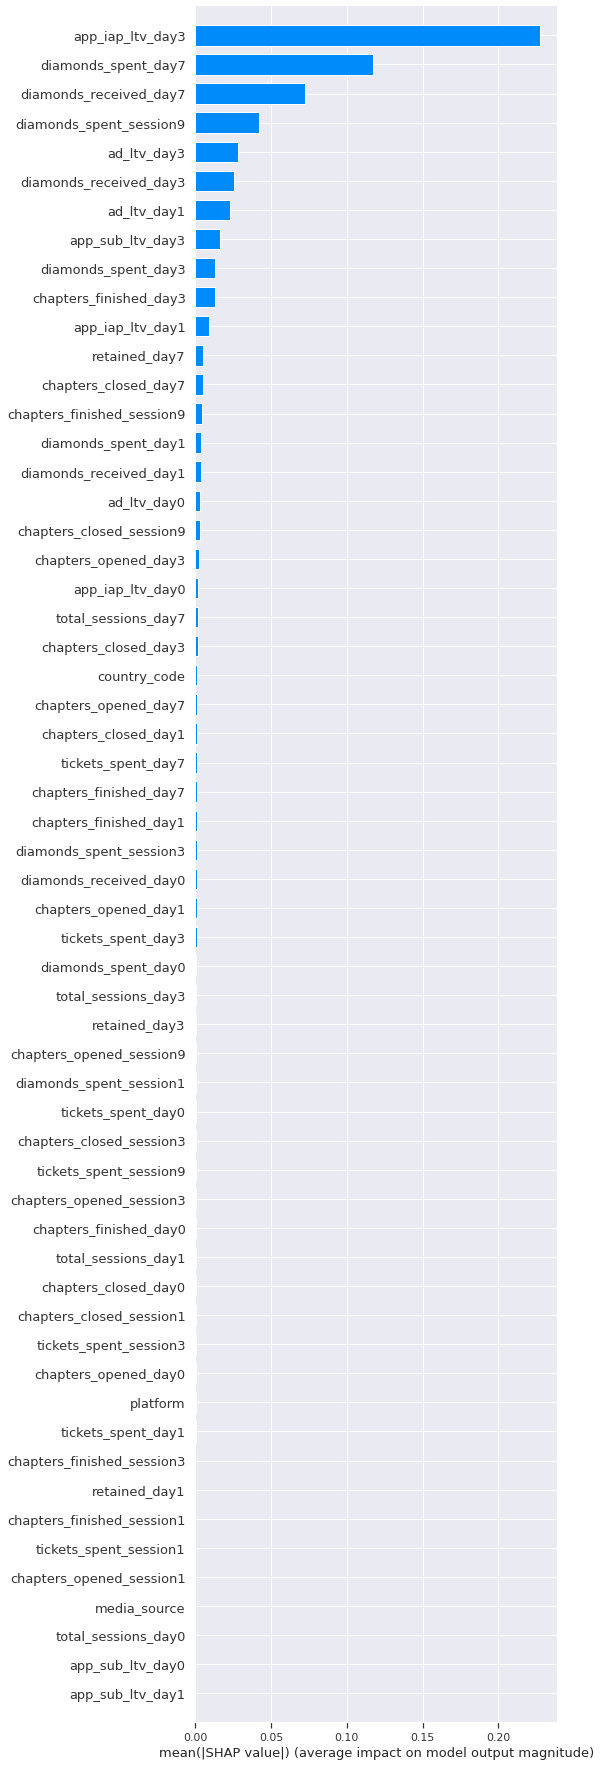

None

,Feature,SHAP
51,app_iap_ltv_day3,0.228
23,diamonds_spent_day7,0.117
19,diamonds_received_day7,0.072
42,diamonds_spent_session9,0.042
56,ad_ltv_day3,0.028
18,diamonds_received_day3,0.025
55,ad_ltv_day1,0.023
48,app_sub_ltv_day3,0.016
22,diamonds_spent_day3,0.013
6,chapters_finished_day3,0.013


In [21]:
feature_importances_table = own_explainer.get_feature_importance(frac=1.0, random_state=47, top_features=None)
feature_importances_table

In [22]:
handle_shap = own_explainer.get_row_force_explaining(iloc_index=0)

calculate shap values...


calculate shap values...


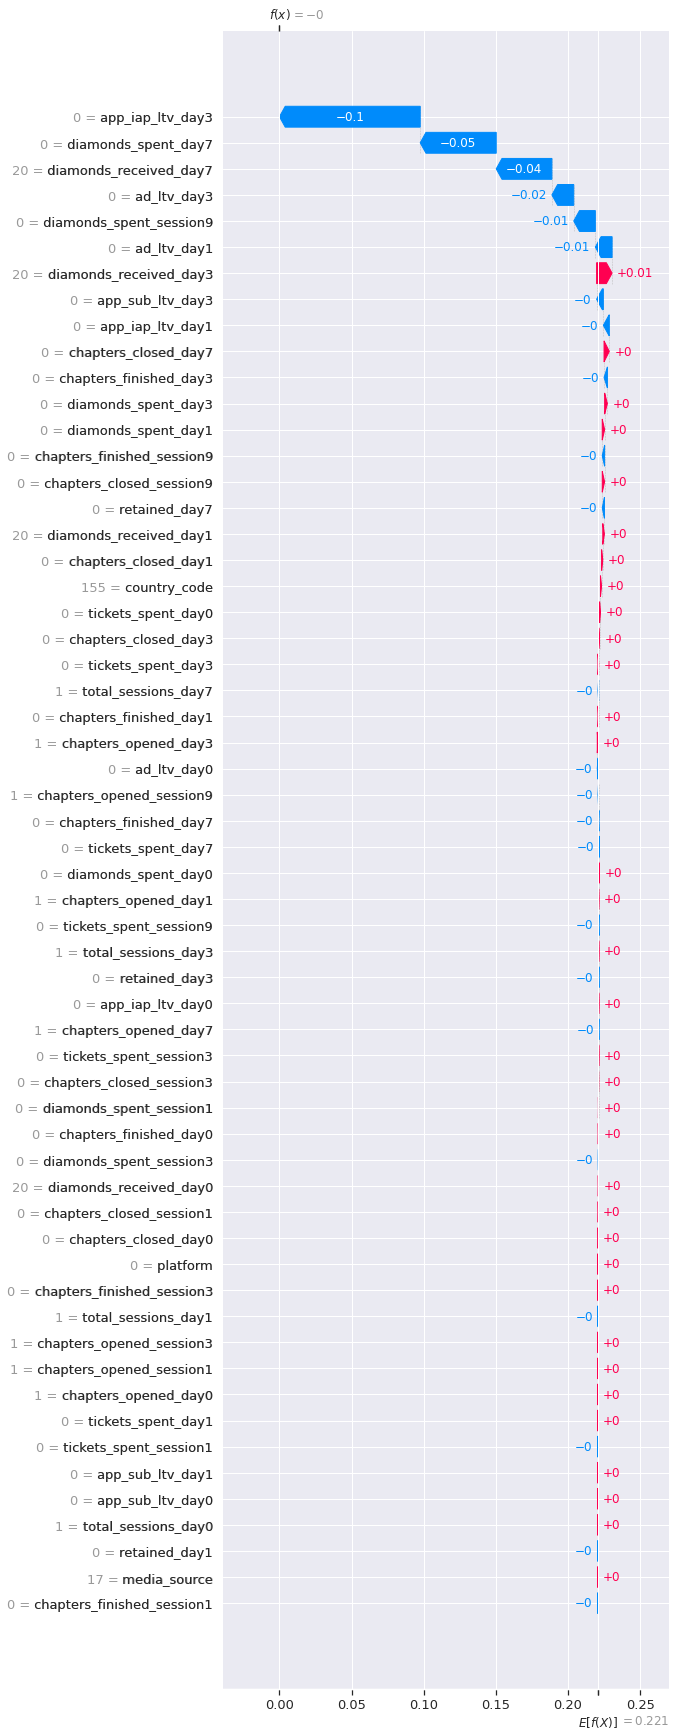

None

In [23]:
handle_shap = own_explainer.get_row_waterfall_explaining(iloc_index=0)

# END